In [2]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import string
from matplotlib import pyplot as plt
%matplotlib inline

# Load data in three arrays

In [3]:
import re

path='CVC-ColonDB/CVC-ColonDB/CVC-ColonDB'
orig_imgs_files = [ f for f in listdir(path) if isfile(join(path,f)) and f[0].isdigit() ]
orig_imgs_files = sorted(orig_imgs_files, key=lambda x: int(re.sub('\D','',x)))

orig_imgs = np.empty(len(orig_imgs_files), dtype=object)
for n in range(0, len(orig_imgs_files)):
    imgg = cv2.imread(join(path,orig_imgs_files[n]), 0)
    orig_imgs[n] = np.zeros(imgg.shape)
    orig_imgs[n] = cv2.normalize(imgg, orig_imgs[n], alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
print ("Read", len(orig_imgs), "original images")

contours_files = [ f for f in listdir(path) if isfile(join(path,f)) and f[0]=='c' ]
contours_files = sorted(contours_files, key=lambda x: int(re.sub('\D','',x)))

contours = np.empty(len(contours_files), dtype=object)
for n in range(0, len(contours_files)):
    contours[n] = cv2.imread(join(path,contours_files[n]), 0)
print ("Read", len(contours), "contour images")

masks_files = [ f for f in listdir(path) if isfile(join(path,f)) and f[0]=='p' ]
masks_files = sorted(masks_files, key=lambda x: int(re.sub('\D','',x)))

masks = np.empty(len(masks_files), dtype=object)
for n in range(0, len(masks_files)):
    masks[n] = cv2.imread(join(path,masks_files[n]), 0)
print ("Read", len(masks), "mask images")

Read 380 original images
Read 380 contour images
Read 380 mask images


# Methods that return different feature vectors

In [4]:
from skimage import measure
from skimage.feature import local_binary_pattern
# To calculate a normalized histogram 
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize

def makeFeatureVector (patch):
    order = 3
    features = []
    features.append(patch.mean())
    features.append(np.median(patch))
    features.append(patch.var())
    features.extend(measure.moments(patch.astype(np.double), order = order).reshape((order + 1)**2))
    return features

def makeLBP(patch):
    #im_gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    radius = 1
    # Number of points to be considered as neighbourers 
    no_points = 8 * radius
    # Uniform LBP is used
    lbp = local_binary_pattern(patch, no_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, normed=True, bins=10, range=(0, n_bins))
    # Normalize the histogram
    #print(hist.shape)
    return list(hist)

In [5]:
patch_size = 25
threshold = 0.01
patches = []
labels = []
k = 0

for n in range (0, len(orig_imgs)):
    for i in range (0, orig_imgs[0].shape[0],patch_size):
        for j in range (0, orig_imgs[0].shape[1] + 1, patch_size):
            patch = orig_imgs[n][i:i+patch_size, j:j+patch_size]
            # Add black color to non-full patches
            if j == 550:
                new_col = np.zeros((25,1), orig_imgs[n][0][0].dtype)
                patch = np.append(patch, new_col, 1)
                
            if (np.sum(masks[n][i:i+patch_size, j:j+patch_size]) >= patch_size * patch_size * threshold):
                patches.append(makeLBP(patch))
                labels.append(True)
            else:
                patches.append(makeLBP(patch))
                labels.append(False)
                
patches = np.array(patches)
labels = np.array(labels)
print("Overall feature matrix: ", patches.shape)
print("Negative samples: ", np.where(labels == 0)[0].shape)
print("Positive samples: ", np.where(labels == 1)[0].shape)

Overall feature matrix:  (174800, 10)
Negative samples:  (156901,)
Positive samples:  (17899,)


# Do class balancing

In [6]:
#Pick 20000 random negative samples
negs = np.random.choice(np.where(labels == 0)[0], 20000)
#Pick 15000 positive samples
poss = np.where(labels == 1)[0]
patches1 = patches[negs].tolist()
patches1.extend(patches[poss[0:15000]].tolist())
labels1 = labels[negs].tolist()
labels1.extend(labels[poss[0:15000]].tolist())
print("Overall feature matrix: ", len(patches1))

Overall feature matrix:  35000


In [7]:
import sys
sys.path.insert(0, 'libsvm-3.22/python/')
from svmutil import *
#labels = np.array(labels)
prob  = svm_problem(labels1, patches1)
param = svm_parameter('-q')
param.cross_validation=0
#param.nr_fold=10
param.kernel_type=RBF
m = svm_train(prob, param)

#Accuracy only on unseen positive samples
p_label, p_acc, p_val = svm_predict(labels[poss[15000:]].tolist(), patches[poss[15000:]].tolist(), m)

Accuracy = 59.2273% (1717/2899) (classification)


In [8]:
#Accuracy on unseen mixed samples
p_label, p_acc, p_val = svm_predict(labels[:15000].tolist(), patches[:15000].tolist(), m)

Accuracy = 73.9667% (11095/15000) (classification)


# Precision and recall

In [11]:
tp = 0
fp = 0
tn = 0
fn = 0
for i,j in zip(p_label, labels[:15000].tolist()):
    if (i == 0 and j == 0):
        tn+=1
    if (i == 0 and j == 1):
        fn+=1
    if (i == 1 and j == 0):
        fp+=1
    if (i == 1 and j == 1):
        tp+=1
        
print(tp, fp, tn, fn)
print(tp/(tp+fp), tp/(tp+fn))
bb=0

674 3521 10421 384
0.1606674612634088 0.6370510396975425


# Test on images

run cell several times to see different images

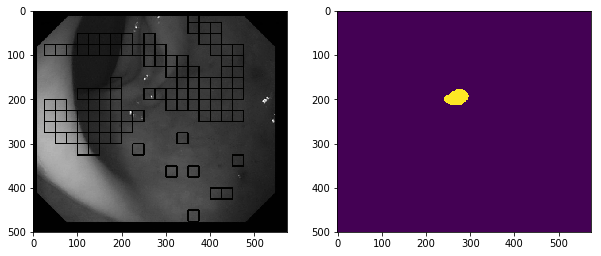

In [12]:
kk = 0
orig_imgs[bb] = cv2.cvtColor(orig_imgs[bb],cv2.COLOR_GRAY2RGB)

for i in range (0, orig_imgs[0].shape[0],patch_size):
    for j in range (0, orig_imgs[0].shape[1] + 1, patch_size):
            
        patch = orig_imgs[bb][i:i+patch_size, j:j+patch_size]
            
        if p_label[bb*460+kk] == 1:
            cv2.rectangle(orig_imgs[bb], (i, j), (i + patch_size, j + patch_size), (255, 255, 0), 2)
        kk+=1
        
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(orig_imgs[bb])

plt.subplot(122)
plt.imshow(masks[bb])
bb+=1

# Unuseful stuff

In [14]:
import tensorflow as tf
from tensorflow.contrib.learn import KMeansClustering

def input_fn():
    return tf.constant(patches,dtype = tf.float32,
                     shape=patches.shape), None

kmeans = tf.contrib.learn.KMeansClustering(num_clusters = 2, use_mini_batch=True, relative_tolerance=0.001)
kmeans.fit(patches, steps=5, batch_size=32)

clusters = kmeans.clusters()
#assignments = list(kmeans.predict_cluster_idx(input_fn=input_fn))

/home/nik/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


KeyboardInterrupt: 

1.0


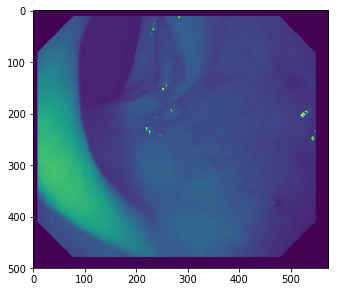

In [66]:
img1 = orig_imgs[0]
cont1 = contours[0]
mask1 = masks[0]
img1
plt.figure(figsize=(18, 15))
plt.subplot(131)
plt.imshow(img1)

#plt.subplot(132)
#plt.imshow(cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB))

patch_x=0
patch_y=0
patch_size=100
patch_image = img1[patch_x:patch_x+patch_size, patch_y:patch_y+patch_size]
#plt.subplot(133)
#plt.imshow(cv2.cvtColor(patch_image, cv2.COLOR_BGR2RGB))
print (img1.max())